# Find Classwise Accuracy

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

1

In [2]:
multi_step = True
num_predicted_steps = 10
model_path = "trained_models_acc/multistep/LSTM3_10steps.h5"

# Load the dataset

In [3]:
dataset = np.load('../data/acc/compressed/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [4]:
def shuffle(x):
    ## Shuffle together two arrays of the exact same dimensions
    idxs = np.arange(x.shape[0])
    np.random.seed(10)
    np.random.shuffle(idxs)
    x = x[idxs]
    return x

dataset = shuffle(dataset)

In [5]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

In [6]:
def multivariate_data(dataset, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = history_size
    end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

In [7]:
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)
val_dataset = dataset[TRAIN_SPLIT_IDX:]
val_data_mean = data_mean[TRAIN_SPLIT_IDX:]
val_data_var = data_var[TRAIN_SPLIT_IDX:]

val_dataset.shape

(7136, 60, 15)

In [8]:
past_history = 15
STEP = 1

x, y = multivariate_data(val_dataset,past_history,
                                                   num_predicted_steps, STEP,
                                                   single_step=not multi_step)

x.shape, y.shape

((249760, 15, 15), (249760, 10, 15))

# Load the model

In [9]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(15*num_predicted_steps))

single_step_model.load_weights(model_path)

single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           73728     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(15*num_predicted_steps))

single_step_model.load_weights(model_path)

single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

In [10]:
y_pred = single_step_model.predict(x, batch_size = 4096).reshape(y.shape)

In [11]:
y_pred.shape, y.shape, len(val_dataset)

((249760, 10, 15), (249760, 10, 15), 7136)

In [12]:
#Optional, if multistep then take last one
if num_predicted_steps > 1:
    #y_pred = y_pred[:, -1, :]
    #y = y[:, -1, :]
    y_pred = np.max(y_pred, axis = 1)
    y = np.max(y, axis = 1)
    
y_pred.shape, y.shape, len(val_dataset)

((249760, 15), (249760, 15), 7136)

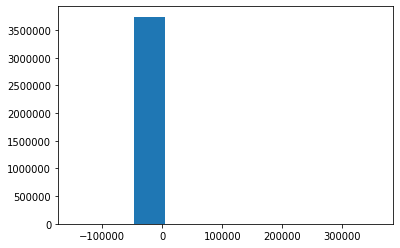

In [13]:
def recover_quake(y_pred, y, means, norms, num_quakes):
    y_pred = y_pred.reshape((num_quakes, -1, 15))
    y = y.reshape((num_quakes, -1, 15))
    
    y = y*np.expand_dims(norms, 1) + np.expand_dims(means, 1)
    y_pred = y_pred*np.expand_dims(norms, 1) + np.expand_dims(means, 1)

    return y, y_pred, (y - y_pred).reshape((-1,))

og_y, og_y_pred, delta = recover_quake(y_pred, y, val_data_mean, val_data_var, len(val_dataset))

plt.figure()
plt.hist(delta)
plt.show()

In [14]:
delta.shape

(3746400,)

In [15]:
def mae(delta):
    return np.mean(np.abs(delta))
mae(delta)

50.94150115377085

In [16]:
mae(delta)/np.mean(val_data_var)

0.1264863877163604

In [17]:
from sklearn import metrics

for y_true, y_pred in [(y, y_pred)]:
    print()
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
    print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
    print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
    print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
    print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
    print("R2 Score:", metrics.r2_score(y_true, y_pred)) 


Explained Variance Score: 0.38004639529810547
Max Error Score: 1.0238174916686422
Mean Absolute Error Score: 0.13697579331731113
Mean Squared Error Score: 0.045485027278205525
Median Absolute Error Score: 0.0724460356444764
R2 Score: 0.08760834888352276


# Alert accuracy

In [18]:
#MMI accel cutoffs (cm/s^2) 
#              I,  II/III  IV        V      VI      VII       VIII      IX    X+
MMI_cutoffs = [    1.667, 13.729, 38.246, 90.221, 176.520, 333.426, 637.432, 1216.025]

In [19]:
og_MMI = np.searchsorted(MMI_cutoffs, og_y.reshape(-1), side = 'right')
og_MMI_pred = np.searchsorted(MMI_cutoffs, og_y_pred.reshape(-1), side = 'right')
print(og_y.shape, og_y_pred.shape, og_MMI.shape, og_MMI_pred.shape)

(7136, 35, 15) (7136, 35, 15) (3746400,) (3746400,)


In [20]:
np.unique(og_MMI, return_counts = True), np.unique(og_MMI_pred, return_counts = True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
  array([ 237546, 2160168,  672593,  307617,  157402,   94127,   52834,
           28735,   35378])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
  array([ 338150, 2319129,  579488,  252079,  118916,   62193,   34803,
           18562,   23080])))

[0, 1, 2, 3, 4, 5, 6, 7, 8]


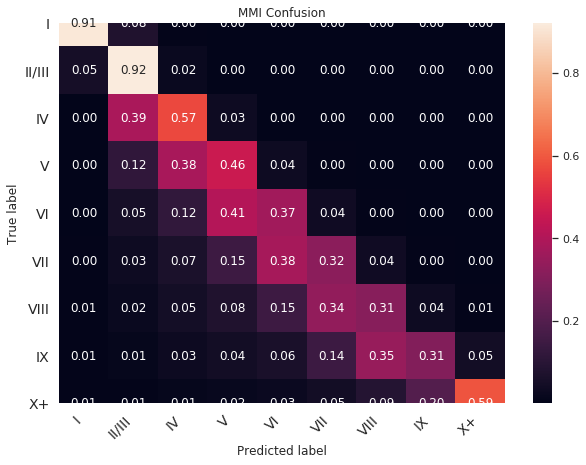

In [21]:
def print_confusion_matrix(confusion_matrix, class_names = None, figsize = (10,7), fontsize=14, labels=None, title=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    sns.set(font_scale=1)
    if class_names == None:
        class_names = list(np.arange(len(confusion_matrix)))
        
    print(class_names)
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')
    
    if labels:
        heatmap.yaxis.set_ticklabels(labels, rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(labels, rotation=45, ha='right', fontsize=fontsize)
    else:
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title != None:
        plt.title(title)
    return fig

cmat = metrics.confusion_matrix(og_MMI, og_MMI_pred)
cmat = cmat / np.expand_dims(np.sum(cmat, axis = 1), 1)
print_confusion_matrix(cmat, labels=["I", "II/III", "IV", "V", "VI", "VII", "VIII", "IX", "X+"], title="MMI Confusion");

In [22]:
alert_thresh = 3  #MMI V
fpr = np.mean(og_MMI_pred[og_MMI < alert_thresh] > alert_thresh)
tnr = np.mean(og_MMI_pred[og_MMI > alert_thresh] < alert_thresh)
fpr, tnr

(0.0016206848370537538, 0.1203280539302424)